In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import quad
from scipy.interpolate import interp1d

from utils import *
from blade_design import blade_design
from rotor import Rotor
from bemt import bemt

### Blade Design with diferent number of blades

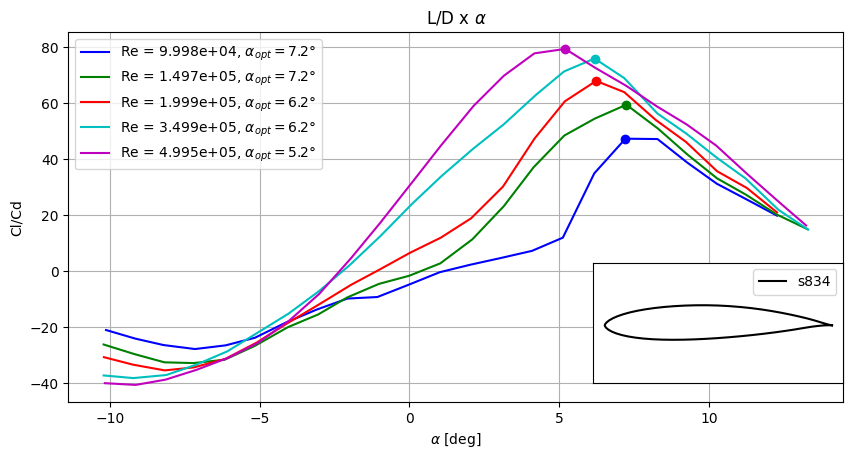

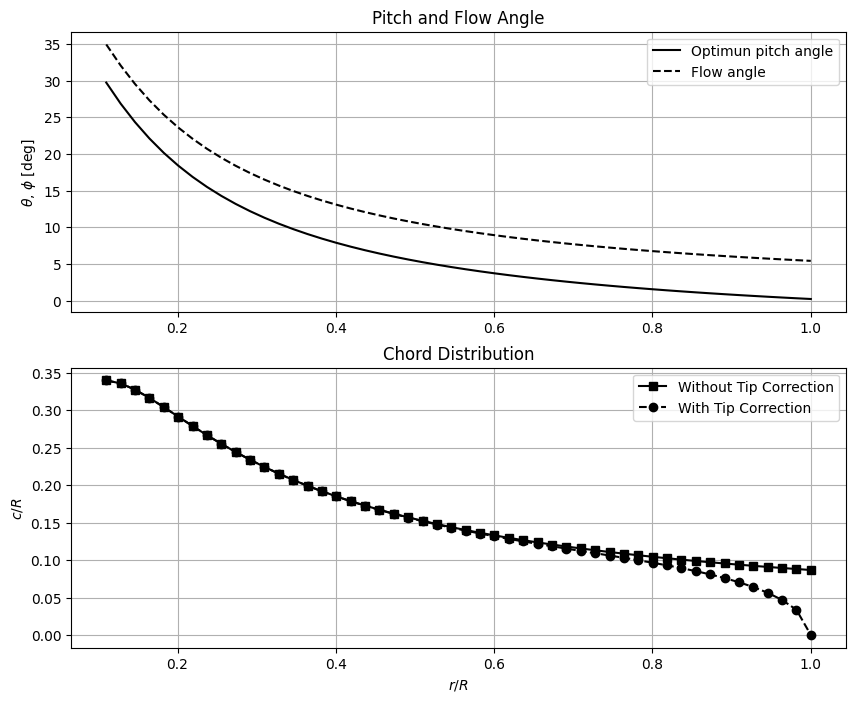

In [2]:
# rotor_uniform = blade_design('s834', 7, 2, number_of_sections=50,plot=True)
rotor_uniform = Rotor(number_of_blades=2, number_of_sections=50, tip_speed_ratio=7, airfoil_name='s834')
rotor_uniform.load_airfoil_prop(plot=True)
rotor_uniform.blade_design(plot=True)

In [4]:
rotor_uniform.sections

,a,a_line,x,r_R,phi,theta_opt,Ct,sigma,c_R,tip_correction
0,0.310577,0.281753,0.770000,0.110000,34.935819,29.735819,0.420070,0.982660,0.339583,1.000000
1,0.314459,0.219610,0.897143,0.128163,32.068906,26.868906,0.388646,0.833828,0.335730,0.999998
2,0.317518,0.175682,1.024286,0.146327,29.541764,24.341764,0.360136,0.711944,0.327280,0.999995
3,0.319948,0.143518,1.151429,0.164490,27.315913,22.115913,0.334444,0.612021,0.316268,0.999990
4,0.321897,0.119294,1.278571,0.182653,25.353185,20.153185,0.311368,0.529811,0.304017,0.999982
5,0.323476,0.100622,1.405714,0.200816,23.618244,18.418244,0.290666,0.461830,0.291361,0.999969
6,0.324766,0.085944,1.532857,0.218980,22.079657,16.879657,0.272083,0.405278,0.278809,0.999952
7,0.325830,0.074209,1.660000,0.237143,20.710110,15.510110,0.255376,0.357929,0.266659,0.999929
8,0.326716,0.064689,1.787143,0.255306,19.486198,14.286198,0.240323,0.318020,0.255073,0.999899
9,0.327460,0.056865,1.914286,0.273469,18.388019,13.188019,0.226722,0.284160,0.244130,0.999860


### Validate Cp curve for Optimum Blade design

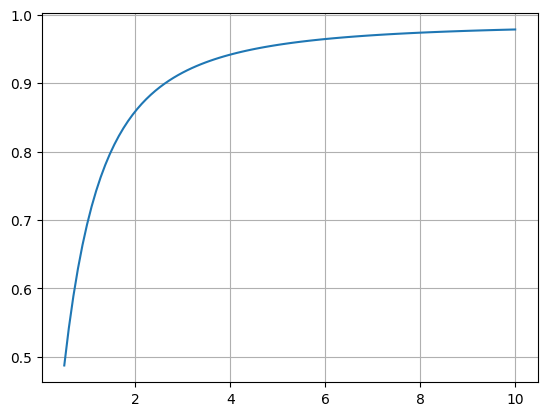

In [2]:
TSR = np.linspace(0.5, 10,  100)
Cp = np.zeros(len(TSR))
for i, tsr in enumerate(TSR):
    rotor = blade_design('s834', tsr, 2, number_of_sections=50, tip_correction_model='', plot = False)
    
    a = rotor['a'].to_numpy() 
    a_line = rotor['a_line'].to_numpy() 
    x = rotor['x'].to_numpy() 
    
    func = interp1d(x, a_line*(1 -a) *x**3, kind='cubic')
    Cp[i] = 8/(tsr**2) * quad(func, x[0], x[-1])[0]
    # Cp[i] = 8/(tsr**2) * np.trapezoid(a_line*(1 - a)*x**3, x)

plt.plot(TSR, 27*Cp/16)
plt.grid()
plt.show()

## Coefficients Extrapolation

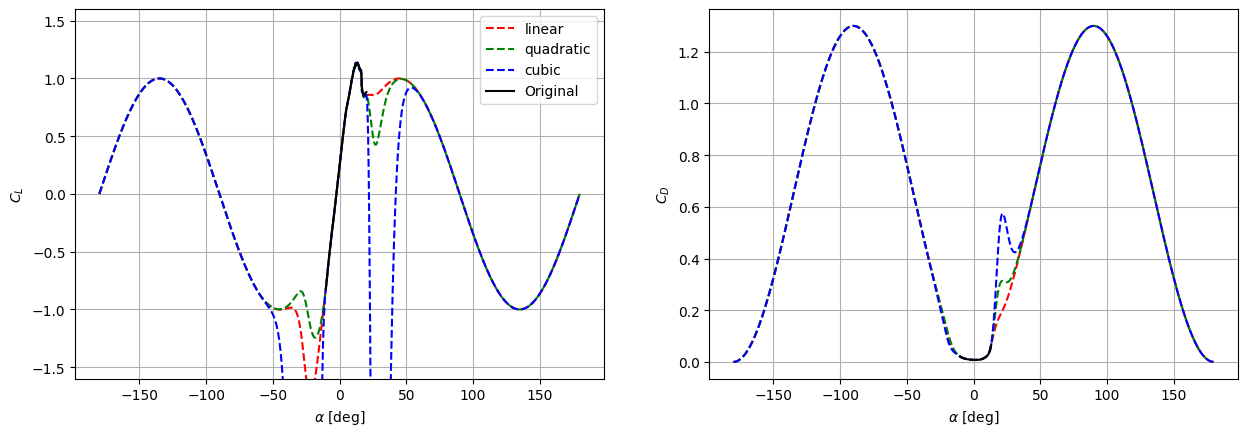

In [17]:
rotor = blade_design('s834', 7, 2, number_of_sections=50,plot=False)
airfoil_name = 's834'
c_lift_drag = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_drg.txt'))
c_lift = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_lft.txt'))

re_drg = list(c_lift_drag.keys())[-1]
re_lft = list(c_lift.keys())[-2:]

Cd = c_lift_drag[re_drg][0][:, 2]
alpha_cd = c_lift_drag[re_drg][0][:, 0]

Cl = np.concatenate([c_lift[re][0][:,1] for re in re_lft])  
alpha_cl = np.concatenate([c_lift[re][0][:,0] for re in re_lft])  

arg = np.argsort(alpha_cl)
alpha_cl = np.sort(alpha_cl)
Cl = Cl[arg]

Cl_mat = np.concatenate((Cl.reshape(-1,1), alpha_cl.reshape(-1,1)), axis = 1)
Cd_mat = np.concatenate((Cd.reshape(-1,1), alpha_cd.reshape(-1,1)), axis = 1)

df_extra_linear = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='linear')
df_extra_quadratic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='quadratic')
df_extra_cubic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='cubic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 4.8])

# ax1.plot(df_extra['alpha'],  df_extra['Cl'], 'r--', label = 'Extrapolation')
ax1.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cl'], 'r--',  label = 'linear')
ax1.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cl'], 'g--',  label = 'quadratic')
ax1.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cl'], 'b--',  label = 'cubic')
ax1.plot(alpha_cl,  Cl, 'k',  label = 'Original')

ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'$C_L$')
# ax1.set_xlim([-45, 45])
ax1.set_ylim([-1.6, 1.6])
ax1.legend()
ax1.grid()

# ax2.plot(df_extra['alpha'],  df_extra['Cd'], 'r--', label = 'Extrapolation')
ax2.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cd'], 'r--',  label = 'linear')
ax2.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cd'], 'g--',  label = 'quadratic')
ax2.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cd'], 'b--',  label = 'cubic')
ax2.plot(alpha_cd,  Cd, 'k', label = 'Original')

ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.set_ylabel(r'$C_D$')
# ax2.set_xlim([-25, 25])
# ax2.set_ylim([0, 0.6])
# ax2.legend()
ax2.grid()


plt.show()



- Smooth transition function

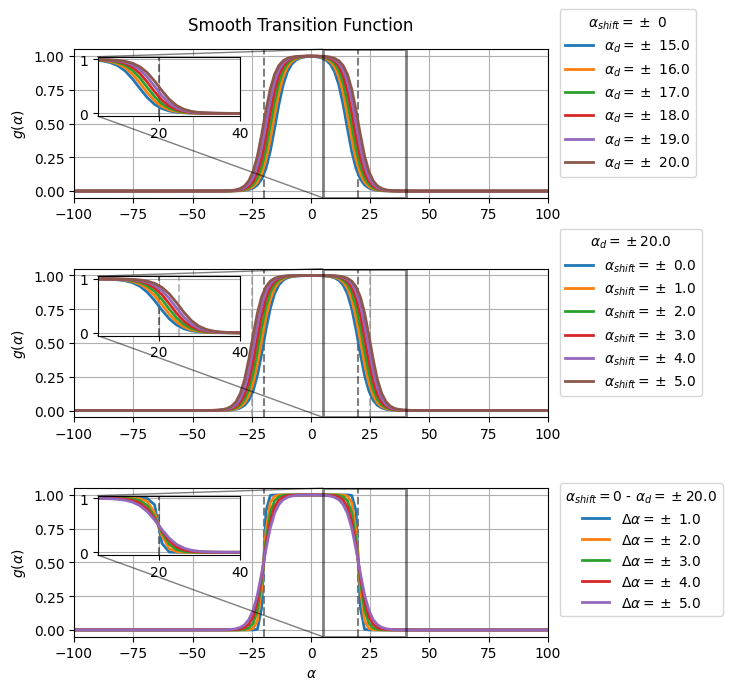

In [6]:
alpha_d = np.deg2rad(20)
alpha_shift = np.deg2rad(5)
delta_alpha = np.deg2rad(5)
alpha = np.linspace(-np.pi, np.pi, 200)


alpha_d_vec = np.deg2rad(np.arange(15, 21))
alpha_shift_vec = np.deg2rad(np.arange(0,6))
delta_alpha_vec = np.deg2rad(np.arange(1, 6))
alpha_vec = np.linspace(-np.pi, np.pi, 200)

g = lambda alpha, alpha_d = alpha_d, alpha_shift = alpha_shift, delta_alpha = delta_alpha: 0.5*(1+np.tanh((alpha_d + alpha_shift  - np.abs(alpha))/delta_alpha))

fig, axis = plt.subplots(3, 1, figsize = [6, 7])
fig.tight_layout(pad=3.0)
fig.suptitle('Smooth Transition Function')
for i, ax in enumerate(axis):
    
    # zoomed plot
    axins = ax.inset_axes([0.05, 0.55, 0.3, 0.4])
    
    # Vertical Lines
    ax.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    ax.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    
    axins.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    axins.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    if i == 1:
        ax.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        ax.axvline(-np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
    
        axins.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        axins.axvline(-np.rad2deg(alpha_d +alpha_shift), linestyle='--', alpha = 0.5, color='gray')


    # Effect of change parameter in smooth transition function
    
    if i == 0:
        for alpha_d in alpha_d_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_d = alpha_d, alpha_shift=0), linewidth=2, label=r'$\alpha_d = \pm$ ' + f'{np.rad2deg(alpha_d):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_d=alpha_d, alpha_shift=0), linewidth=2)
            # ax.set_title('Smooth Transition function')
            title = r'$\alpha_{shift} = \pm$ 0'
    elif i == 1:
        for alpha_shift in alpha_shift_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift = alpha_shift), linewidth=2, label=r'$\alpha_{shift} = \pm$ ' + f'{np.rad2deg(alpha_shift):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=alpha_shift), linewidth=2)
            title = r'$\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    elif i == 2:
        for delta_alpha in delta_alpha_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha = delta_alpha), linewidth=2, label=r'$\Delta \alpha = \pm$ ' + f'{np.rad2deg(delta_alpha):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha=delta_alpha), linewidth=2)
            ax.set_xlabel(r'$\alpha$')
            title = r'$\alpha_{shift} = 0$ - $\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    # else:
    #     ax.plot(np.rad2deg(alpha), g(alpha), linewidth=2, color='black', label=r'$g(\alpha)$')


    ax.set_ylabel(r'$g(\alpha)$')
    # ax.set_xticks(np.arange(-180,190,10))
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.set_xlim([-100, 100])
    ax.legend(title = title, bbox_to_anchor=(1.01, 0.095))
    ax.grid()

    axins.set_xlim(5, 40)
    axins.grid()

    ax.indicate_inset_zoom(axins, linewidth=2, edgecolor="black")

plt.show()


### Validate BEMT

In [7]:

# rotor